In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

from functions.datasets import get_loaders
from functions.loop_management import EarlyStopping
from functions.mapping import extract_bboxes
from functions.plotting import plot_losses

print(torch.__version__)
print(torch.cuda.is_available())

2.3.1
True


In [2]:
dataset, train_loader, valid_loader = get_loaders(
    os.path.join("data", "train_images"),
    os.path.join("data", "train_coco_annotations.json"),
    prefetch_factor=16
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
cuda


In [3]:
class BoundingBoxModel(nn.Module):
    def __init__(self):
        super(BoundingBoxModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = self._initialize_fc1()
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self._run_first_layers(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def _initialize_fc1(self) -> nn.Linear:
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 200)
            x = self._run_first_layers(dummy_input)
            input_size = x.size(1)

            return nn.Linear(input_size, 128)

    def _run_first_layers(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)

        return x

In [4]:
model = BoundingBoxModel().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
early_stopping = EarlyStopping(patience=7, verbose=True)
num_epochs = 25
epochs_used = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training")

    for images, targets in train_loader_tqdm:
        images = images.to(device)
        bboxes = extract_bboxes(targets)
        bboxes = torch.stack(bboxes).to(device)

        optimizer.zero_grad(set_to_none=True)

        outputs = model(images)
        loss = criterion(outputs, bboxes)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        train_loader_tqdm.set_postfix({"Train Loss": running_loss / len(train_loader)})

    epoch_train_loss = running_loss / len(train_loader)

    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch + 1}, Loss: {epoch_train_loss}")
    model.eval()

    val_loss = 0.0
    valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation")

    with torch.no_grad():
        for images, targets in valid_loader_tqdm:
            images = images.to(device)
            bboxes = extract_bboxes(targets)
            bboxes = torch.stack(bboxes).to(device)
            outputs = model(images)
            loss = criterion(outputs, bboxes)
            val_loss += loss.item()

            valid_loader_tqdm.set_postfix({"Val Loss": val_loss / len(valid_loader)})

    epoch_val_loss = val_loss / len(valid_loader)
    epochs_used += 1

    val_losses.append(epoch_val_loss)
    print(f"Validation Loss: {epoch_val_loss}")

    early_stopping(
        epoch_val_loss, 
        model, 
        path=os.path.join("checkpoints", "checkpoint_2_bigger_basic.pt")
    )

    if early_stopping.early_stop:
        print("Early stopping")
        break

print("Training complete")

Epoch 1/25 - Training: 100%|██████████| 227/227 [00:17<00:00, 13.05it/s, Train Loss=16.7]


Epoch 1, Loss: 16.708877907975655


Epoch 1/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.81it/s, Val Loss=11.9]


Validation Loss: 11.947258844249575
Validation loss decreased (inf --> 11.947259).  Saving model ...


Epoch 2/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.55it/s, Train Loss=9.77]


Epoch 2, Loss: 9.772331996111092


Epoch 2/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.81it/s, Val Loss=9.92]


Validation Loss: 9.919346366159717
Validation loss decreased (11.947259 --> 9.919346).  Saving model ...


Epoch 3/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.67it/s, Train Loss=8.7] 


Epoch 3, Loss: 8.702230001861304


Epoch 3/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.04it/s, Val Loss=9.73]


Validation Loss: 9.727285935490142
Validation loss decreased (9.919346 --> 9.727286).  Saving model ...


Epoch 4/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.72it/s, Train Loss=8.17]


Epoch 4, Loss: 8.166902481196736


Epoch 4/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.13it/s, Val Loss=7.86]


Validation Loss: 7.864416460633803
Validation loss decreased (9.727286 --> 7.864416).  Saving model ...


Epoch 5/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.72it/s, Train Loss=7.9] 


Epoch 5, Loss: 7.900160117296395


Epoch 5/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.05it/s, Val Loss=8.42]


Validation Loss: 8.42011921836416
EarlyStopping counter: 1 out of 7


Epoch 6/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.89it/s, Train Loss=7.49]


Epoch 6, Loss: 7.491732870429623


Epoch 6/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.14it/s, Val Loss=8]   


Validation Loss: 7.9968847472237075
EarlyStopping counter: 2 out of 7


Epoch 7/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.60it/s, Train Loss=7.35]


Epoch 7, Loss: 7.345408011112969


Epoch 7/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.05it/s, Val Loss=6.77]


Validation Loss: 6.773413937522451
Validation loss decreased (7.864416 --> 6.773414).  Saving model ...


Epoch 8/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.74it/s, Train Loss=7.19]


Epoch 8, Loss: 7.192867245443066


Epoch 8/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.15it/s, Val Loss=6.58]


Validation Loss: 6.578620019988342
Validation loss decreased (6.773414 --> 6.578620).  Saving model ...


Epoch 9/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.58it/s, Train Loss=7.18]


Epoch 9, Loss: 7.178947912964001


Epoch 9/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.98it/s, Val Loss=7.88]


Validation Loss: 7.87988091145318
EarlyStopping counter: 1 out of 7


Epoch 10/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.58it/s, Train Loss=6.75]


Epoch 10, Loss: 6.747271896984084


Epoch 10/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.12it/s, Val Loss=6.4] 


Validation Loss: 6.40403432678021
Validation loss decreased (6.578620 --> 6.404034).  Saving model ...


Epoch 11/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.29it/s, Train Loss=6.77]


Epoch 11, Loss: 6.768572498523191


Epoch 11/25 - Validation: 100%|██████████| 227/227 [00:14<00:00, 15.49it/s, Val Loss=6.58]


Validation Loss: 6.582078051462047
EarlyStopping counter: 1 out of 7


Epoch 12/25 - Training: 100%|██████████| 227/227 [00:14<00:00, 15.94it/s, Train Loss=6.51]


Epoch 12, Loss: 6.510717555814903


Epoch 12/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.02it/s, Val Loss=6.52]


Validation Loss: 6.516592342948074
EarlyStopping counter: 2 out of 7


Epoch 13/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.68it/s, Train Loss=6.19]


Epoch 13, Loss: 6.193958700490943


Epoch 13/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.83it/s, Val Loss=5.96]


Validation Loss: 5.9567854267910185
Validation loss decreased (6.404034 --> 5.956785).  Saving model ...


Epoch 14/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.70it/s, Train Loss=6.14]


Epoch 14, Loss: 6.1369460206725


Epoch 14/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.20it/s, Val Loss=5.73]


Validation Loss: 5.72945039597902
Validation loss decreased (5.956785 --> 5.729450).  Saving model ...


Epoch 15/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.64it/s, Train Loss=6.03]


Epoch 15, Loss: 6.03272728983001


Epoch 15/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.06it/s, Val Loss=6.2] 


Validation Loss: 6.195511725505543
EarlyStopping counter: 1 out of 7


Epoch 16/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.62it/s, Train Loss=5.72]


Epoch 16, Loss: 5.7236225090362955


Epoch 16/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.00it/s, Val Loss=6.06]


Validation Loss: 6.06021034770075
EarlyStopping counter: 2 out of 7


Epoch 17/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.76it/s, Train Loss=5.54]


Epoch 17, Loss: 5.541102549052973


Epoch 17/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.15it/s, Val Loss=5.1] 


Validation Loss: 5.10422272724202
Validation loss decreased (5.729450 --> 5.104223).  Saving model ...


Epoch 18/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.56it/s, Train Loss=5.52]


Epoch 18, Loss: 5.52485473985714


Epoch 18/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.97it/s, Val Loss=5.29]


Validation Loss: 5.2860658840986074
EarlyStopping counter: 1 out of 7


Epoch 19/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.83it/s, Train Loss=5.48]


Epoch 19, Loss: 5.479590373942505


Epoch 19/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.17it/s, Val Loss=6.75]


Validation Loss: 6.753530313264956
EarlyStopping counter: 2 out of 7


Epoch 20/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.85it/s, Train Loss=5.23]


Epoch 20, Loss: 5.226937486211634


Epoch 20/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.81it/s, Val Loss=4.95]


Validation Loss: 4.952206745021669
Validation loss decreased (5.104223 --> 4.952207).  Saving model ...


Epoch 21/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.56it/s, Train Loss=5.09]


Epoch 21, Loss: 5.090460860256582


Epoch 21/25 - Validation: 100%|██████████| 227/227 [00:13<00:00, 17.20it/s, Val Loss=4.95]


Validation Loss: 4.9469712946383435
Validation loss decreased (4.952207 --> 4.946971).  Saving model ...


Epoch 22/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.93it/s, Train Loss=5.01]


Epoch 22, Loss: 5.009560231070162


Epoch 22/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.60it/s, Val Loss=5.68]


Validation Loss: 5.68122260475999
EarlyStopping counter: 1 out of 7


Epoch 23/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.53it/s, Train Loss=4.9] 


Epoch 23, Loss: 4.89874524376991


Epoch 23/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.09it/s, Val Loss=6.1] 


Validation Loss: 6.095254351914192
EarlyStopping counter: 2 out of 7


Epoch 24/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.67it/s, Train Loss=4.91]


Epoch 24, Loss: 4.906252163622348


Epoch 24/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.15it/s, Val Loss=4.39]


Validation Loss: 4.3881333031843415
Validation loss decreased (4.946971 --> 4.388133).  Saving model ...


Epoch 25/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.53it/s, Train Loss=4.66]


Epoch 25, Loss: 4.659874098941618


Epoch 25/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.12it/s, Val Loss=4.86]

Validation Loss: 4.86401995688283
EarlyStopping counter: 1 out of 7
Training complete


C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py

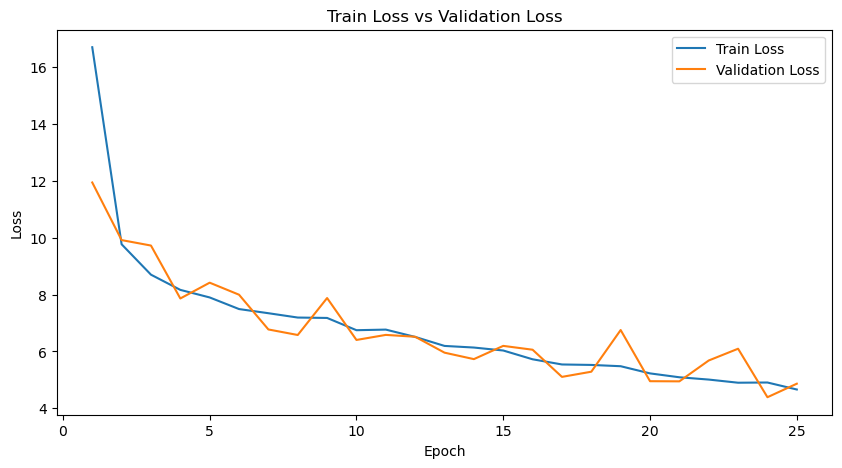

In [6]:
plot_losses(epochs_used, train_losses, val_losses)

In [7]:
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': -early_stopping.best_score,
}
torch.save(checkpoint, os.path.join("checkpoints", "checkpoint_2_bigger_basic.pt"))